# H.4] Imaginary Time Evolution
d) Numerically integrate random initial state up to certain time $\tau_{\text{max}}$

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import reduce
from scipy.sparse import identity, kron, csr_matrix

In [50]:
# Set parameters
N = 4
tau_max = 5
Nsteps = 100
dt = tau_max/Nsteps

In [51]:
# Create random initial state
psi0 = np.random.randn(2**N) + 1j*np.random.randn(2**N)

# Normalize
psi0 /= np.linalg.norm(psi0) 
print('Initial state |psi(0)> = ', psi0)

Initial state |psi(0)> =  [ 0.07742688+0.1197014j  -0.12043332-0.02262699j -0.05086578+0.00077554j
  0.08261864-0.12298562j -0.13213929+0.3471961j  -0.03122999+0.35800581j
 -0.29375584-0.02650945j -0.14564983+0.32031625j  0.16973893+0.05216668j
  0.0624873 -0.19387596j -0.07790286-0.01821746j  0.36432349-0.22089787j
 -0.21079927+0.00713022j -0.16333706+0.00298429j -0.18104677-0.22384998j
 -0.07669057-0.20313433j]


In [52]:
# Create Hamiltonian as matrix as done in last sheet:

# Create csr Pauli matrices
id = identity(2, format='csr')
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=np.float64)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=np.float64)

def kronecker(operators):
    # reduce calls the function (first arg) recursively on the list (second arg)
    return reduce(kron, operators)

def build_operator(operator, ind, L):
    # list of L identity operators
    operators = [id] * L

    # replace the ind-th operator with the given operator
    operators[ind] = operator

    # return the kronecker product of all identity matrices and the operator on site ind
    return csr_matrix(kronecker(operators))

def all_operators(operator):
    # a list of L operators, each one acting on a different site, otherwise identity
    return [build_operator(operator, j, N) for j in range(N)]

def Hamiltonian(h=1, J=1):
    # initialize matrices
    H = csr_matrix((2**N, 2**N), dtype=np.complex128)
    sz_list = all_operators(sigma_z)
    sx_list = all_operators(sigma_x)

    for i in range(N-1):
        H += J*(sz_list[i] @ sz_list[i+1]) + h*(sx_list[i])
    return H

In [ ]:
# Define derivative using imaginary time SEQ
def dpsi_dtau(tau, psi, h=1, J=1):
    psi = psi.view(dtype=np.complex128)
    return (Hamiltonian(h,J) @ psi).view(dtype=np.float64)

# Numerically integrate this state using real part of initial state |psi(0)>
sol = solve_ivp(dpsi_dtau, t_span = (0, tau_max), y0 = psi0.view(dtype=np.float64), t_eval=np.linspace(0, tau_max, Nsteps))

# Normalize wave functions of each step dt
psi_tau_list = sol.y.T.copy().view(dtype=np.complex128)   # copy to ensure that the memory is laid out cpntiguously before using  changing the data type to complex128
psi_tau_normalized = np.array([psi / np.linalg.norm(psi) for psi in psi_tau_list])

(16,)


e) Monitor convergence to ground state energy

In [ ]:
# Compute energy expectation value
def E(psi, h=1, J=1):
    return np.real(np.vdot(psi, Hamiltonian(h,J) @ psi))

t = 0
E_tau = np.array([])
tau_list = np.linspace(0, tau_max, Nsteps)
for i in range(Nsteps):
    E_tau = np.append(E_tau, E(psi_tau_normalized[i]))

100 100


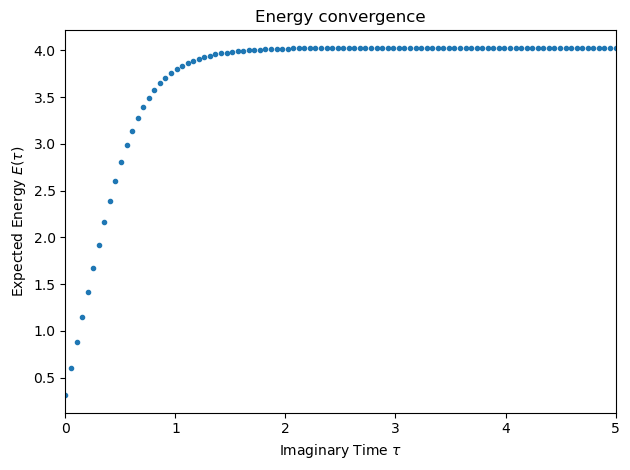

In [71]:
# Plot energy expectation value over time tau
plt.scatter(tau_list,E_tau, marker='.')

plt.xlabel(r'Imaginary Time $\tau$')
plt.ylabel(r'Expected Energy $E(\tau)$')
plt.title('Energy convergence')
plt.xlim(min(tau_list),max(tau_list))

plt.tight_layout()
plt.show()

f) Check if ITP ground state is correct

g) Compare efficiency of ITP vs real-time adiabatic evolution